In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [50]:
# Configuration
base_dir = "/scicore/home/schwede/pudziu0000/projects/gLM/logs/CategoricalJacobianCNN"
model_class = "Softmax_CV_I"
metric_of_interest = "pr_auc"  # Change to 'roc_auc', 'pr_auc', etc. if needed
num_experiments = 10  # Set the actual number of experiments
num_folds = 5        # Set the actual number of folds

In [42]:
def get_accuracy(row):
    tp = row["tp"].values[0]
    tn = row["tn"].values[0]
    fp = row["fp"].values[0]
    fn = row["fn"].values[0]
    denom = tp + tn + fp + fn
    metric_value = (tp + tn) / denom if denom > 0 else 0.0
    return metric_value

No checkpoint found for exp 0, fold 0
No checkpoint found for exp 0, fold 1
No checkpoint found for exp 0, fold 2
No checkpoint found for exp 0, fold 3
No checkpoint found for exp 0, fold 4


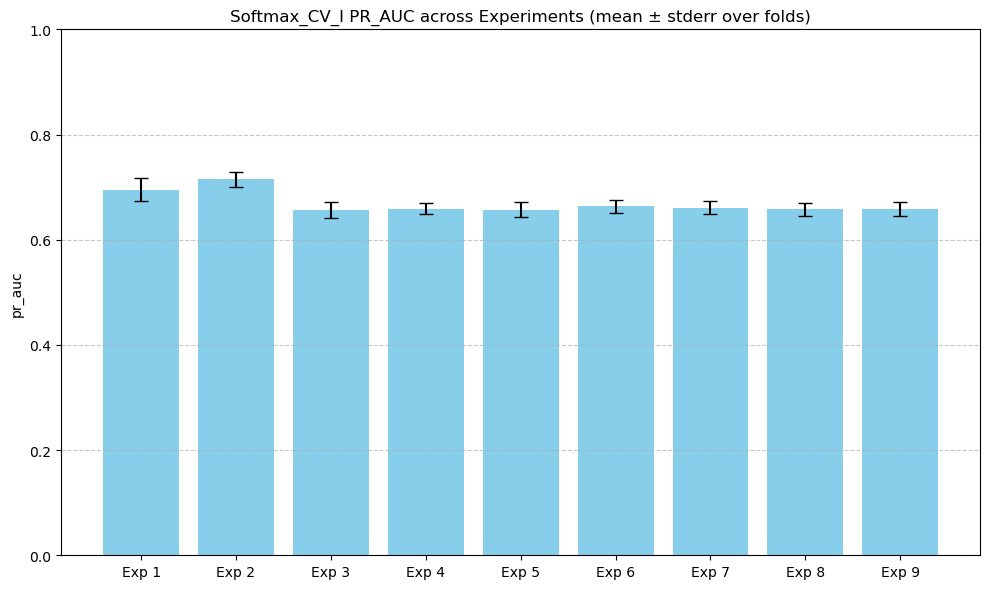

In [51]:
# Container for results
experiment_results = {}

for exp_num in range(num_experiments):
    fold_metrics = []
    for fold_num in range(num_folds):
        # Define paths
        fold_path = f"{base_dir}/{model_class}_{exp_num:02d}/gLM2/{fold_num}"
        ckpt_path = glob(f"{fold_path}/checkpoints/model-epoch=*.ckpt")

        if not ckpt_path:
            print(f"No checkpoint found for exp {exp_num}, fold {fold_num}")
            continue
        
        # Extract best epoch
        match = re.search(r"model-epoch=(\d+)\.ckpt", os.path.basename(ckpt_path[0]))
        if not match:
            print(f"Could not extract epoch from checkpoint for exp {exp_num}, fold {fold_num}")
            continue
        best_epoch = int(match.group(1))

        # Read metrics
        metrics_file = os.path.join(fold_path, "metrics.csv")
        if not os.path.isfile(metrics_file):
            print(f"No metrics.csv found for exp {exp_num}, fold {fold_num}")
            continue
        df = pd.read_csv(metrics_file)

        # Drop the first duplicate line of epoch 0
        df = df[~((df.epoch == 0) & (df.index == df[df.epoch == 0].index.min()))]

        # Get metric at best epoch
        row = df[df.epoch == best_epoch]
        if row.empty:
            print(f"No data for best epoch {best_epoch} in exp {exp_num}, fold {fold_num}")
            continue

        if metric_of_interest == "accuracy":
            required_cols = {"tn", "fp", "fn", "tp"}
            if not required_cols.issubset(row.columns):
                print(f"Missing columns for accuracy in exp {exp_num}, fold {fold_num}")
                continue
            metric_value = get_accuracy(row)
        else:
            metric_value = row[metric_of_interest].values[0]
        fold_metrics.append(metric_value)

    if fold_metrics:
        experiment_results[exp_num] = fold_metrics

# Plotting
means = []
stderrs = []
labels = []

for exp_num, metrics in experiment_results.items():
    mean_val = sum(metrics) / len(metrics)
    stderr_val = pd.Series(metrics).std()/len(metrics)**(1/2)
    means.append(mean_val)
    stderrs.append(stderr_val)
    labels.append(f"Exp {exp_num}")

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(labels, means, yerr=stderrs, capsize=5, color='skyblue')
plt.ylabel(metric_of_interest)
plt.title(f"{model_class} {metric_of_interest.upper()} across Experiments (mean ± stderr over folds)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
